In [1]:
!pip install torch_snippets torch_summary --quiet
import itertools
from PIL import Image
from torch_snippets import *
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary
from glob import glob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.3 MB/s eta 0:0

In [2]:
from google.colab import drive # mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
imgage = Image.open('/content/drive/MyDrive/Dataset/testA/00130.jpg') # choose a test image and display the size 
imgage.size

(256, 256)

In [4]:
IMAGE_SIZE = 256 # Initializes an image preprocessing pipeline with resizing, random cropping, flipping, and normalization for PyTorch models.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.33)),
    transforms.RandomCrop((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [5]:
class Monet2PhotoDataset(Dataset): # Loading the Monet_to_Photo Dataset using PyTorch
    def __init__(self, monets_path, photos_path):
        # getting the list of images using glob
        self.monets = glob(monets_path + '/*.jpg')
        self.photos = glob(photos_path + '/*.jpg')

    def __getitem__(self, ix):
        monet = self.monets[ix % len(self.monets)]
        # Choosing a random photo image to pair with the chosen Monet image
        photo = self.photos[random.randint(0, len(self.photos) - 1)]
        monet = Image.open(monet).convert('RGB')
        photo = Image.open(photo).convert('RGB')
        return transform(monet), transform(photo)

    def __len__(self):
        return max(len(self.monets), len(self.photos))

    # The collate_fn can stay outside the Dataset class
    @staticmethod
    def collate_fn(batch):
        # The zip function breaks the tuples into two lists
        monets, photos = list(zip(*batch))
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # No need to add [None], ToTensor already adds the batch dimension
        monets = torch.cat([img.unsqueeze(0) for img in monets], dim=0).to(device)
        photos = torch.cat([img.unsqueeze(0) for img in photos], dim=0).to(device)
        return monets, photos

In [6]:
train_monets_path = '/content/drive/MyDrive/Dataset/trainA' # Giving the training path to monets
train_photos_path = '/content/drive/MyDrive/Dataset/trainB'
test_monets_path = '/content/drive/MyDrive/Dataset/testA'
test_photos_path = '/content/drive/MyDrive/Dataset/testB'

# Create the dataset instances
trn_ds = Monet2PhotoDataset(train_monets_path, train_photos_path)
val_ds = Monet2PhotoDataset(test_monets_path, test_photos_path)

# Create the DataLoader instances
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=Monet2PhotoDataset.collate_fn)
val_dl = DataLoader(val_ds, batch_size=5, shuffle=True, collate_fn=Monet2PhotoDataset.collate_fn)

In [7]:
def weights_init_normal(m): # Setting weights for the network to learn easily 
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [8]:
class ResidualBlock(nn.Module): # adding new features to input

    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [9]:
class GeneratorResNet(nn.Module): # Generator with ResNet blocks for transforming images
    def __init__(self, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        out_features = 64
        channels = 3
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
        self.apply(weights_init_normal)
    def forward(self, x):
        return self.model(x)

In [10]:
class Discriminator(nn.Module): # Creates a Discriminator to differentiate real images from generated ones

    def __init__(self):
        super(Discriminator, self).__init__()

        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weights_init_normal)

    def forward(self, img):
        return self.model(img)


In [11]:
@torch.no_grad() # Displays a grid comparing real and generated images, without model updates.
def generate_sample():
    data = next(iter(val_dl))
    G_AB.eval()
    G_BA.eval()

    real_A, real_B = data
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    show(image_grid.detach().cpu().permute(1,2,0).numpy(), sz=12)

In [12]:
def generator_train_step(Gs, optimizer, real_A, real_B): # Training the Generator of CycleGAN
    G_AB, G_BA = Gs
    optimizer.zero_grad()
    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)

    loss_identity = (loss_id_A + loss_id_B) / 2
    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))

    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)

    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
    loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
    loss_G.backward()
    optimizer.step()
    return loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B

In [13]:
def discriminator_train_step(D, real_data, fake_data, optimizer): # Training the Discriminator of the CycleGAN
    optimizer.zero_grad()
    loss_real = criterion_GAN(D(real_data), torch.Tensor(np.ones((len(real_data), 1, 16, 16))).to(device))
    loss_fake = criterion_GAN(D(fake_data.detach()), torch.Tensor(np.zeros((len(real_data), 1, 16, 16))).to(device))
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer.step()
    return loss_D

In [14]:
G_AB = GeneratorResNet().to(device) # Setting up CycleGAN's generators, discriminators, loss functions, and optimizers for image translation tasks.
G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_cyc, lambda_id = 10.0, 5.0

EPOCH: 1.000  loss_D: 0.163  loss_G: 4.656  loss_GAN: 0.668  loss_cycle: 0.253  loss_identity: 0.292  (3298.22s - 13192.87s remaining)

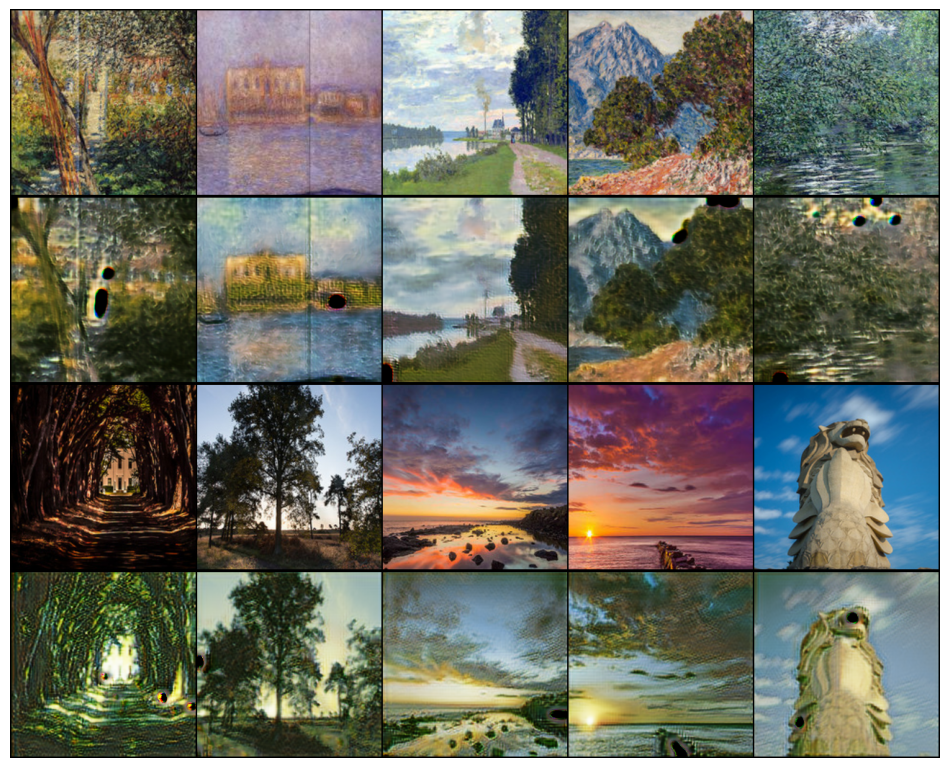

EPOCH: 1.000  loss_GAN: 0.553  loss_cycle: 0.249  loss_identity: 0.228  loss_G: 4.182  loss_D: 0.207  (3304.08s - 13216.33s remaining)
EPOCH: 2.000  loss_D: 0.241  loss_G: 3.342  loss_GAN: 0.198  loss_cycle: 0.221  loss_identity: 0.188  (5533.14s - 8299.72s remaining)

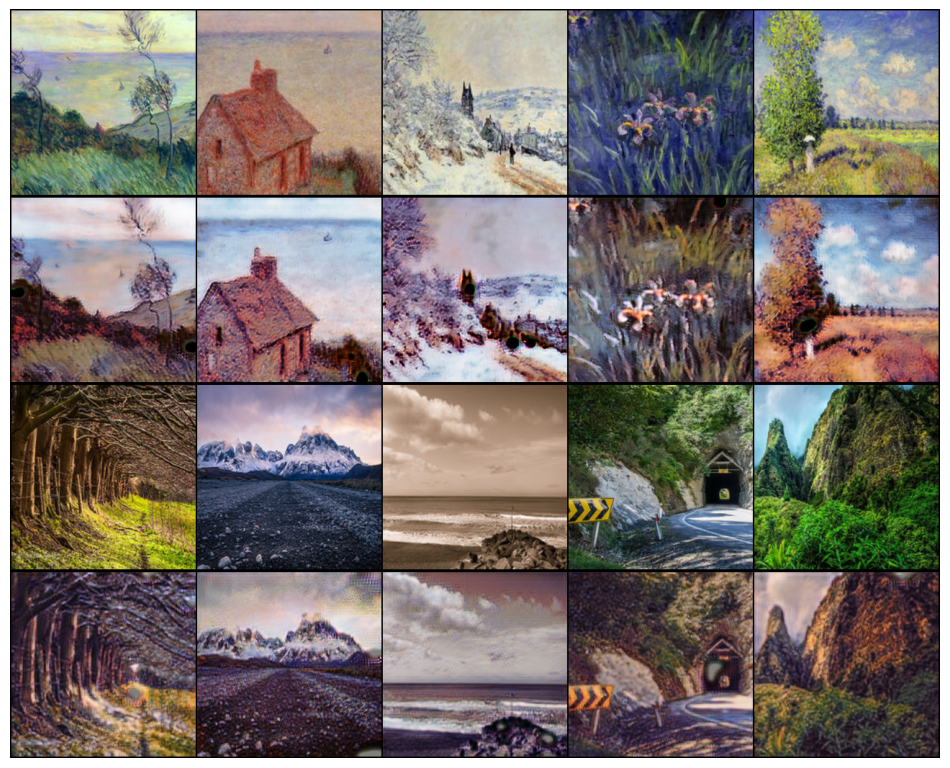

EPOCH: 2.000  loss_GAN: 0.556  loss_cycle: 0.206  loss_identity: 0.189  loss_G: 3.561  loss_D: 0.187  (5538.23s - 8307.34s remaining)
EPOCH: 3.000  loss_D: 0.070  loss_G: 4.025  loss_GAN: 0.630  loss_cycle: 0.230  loss_identity: 0.219  (7210.48s - 4806.99s remaining)

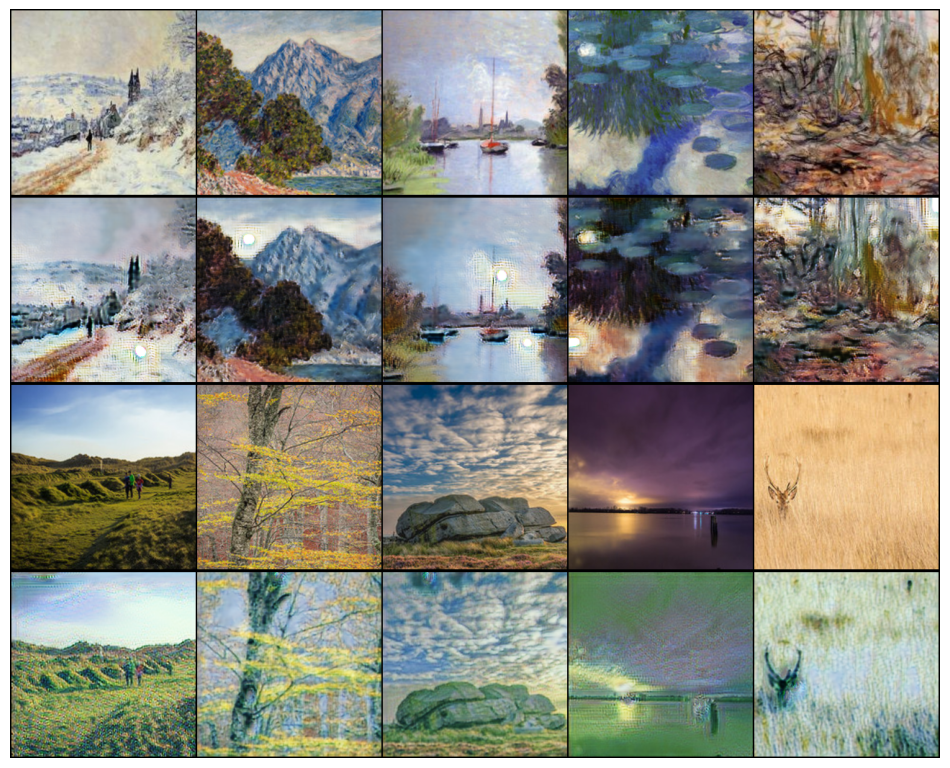

EPOCH: 3.000  loss_GAN: 0.533  loss_cycle: 0.191  loss_identity: 0.175  loss_G: 3.319  loss_D: 0.190  (7216.35s - 4810.90s remaining)
EPOCH: 4.000  loss_D: 0.039  loss_G: 3.539  loss_GAN: 0.814  loss_cycle: 0.187  loss_identity: 0.171  (8744.94s - 2186.23s remaining)

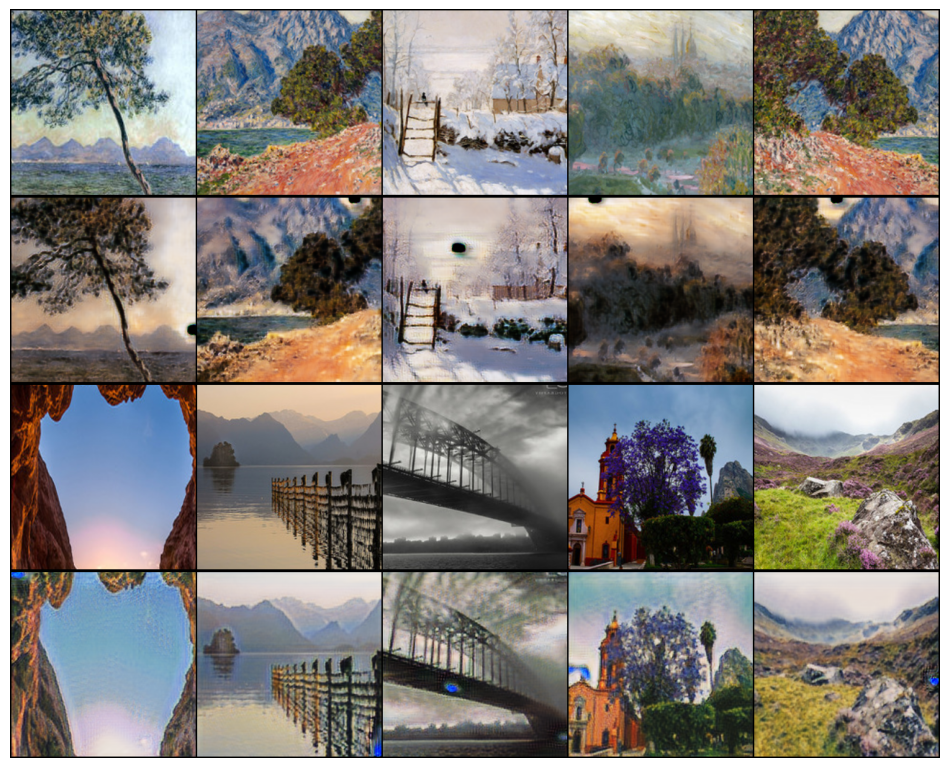

EPOCH: 4.000  loss_GAN: 0.591  loss_cycle: 0.187  loss_identity: 0.171  loss_G: 3.313  loss_D: 0.166  (8749.99s - 2187.50s remaining)
EPOCH: 5.000  loss_D: 0.301  loss_G: 3.105  loss_GAN: 0.351  loss_cycle: 0.193  loss_identity: 0.165  (10213.57s - 0.00s remaining)

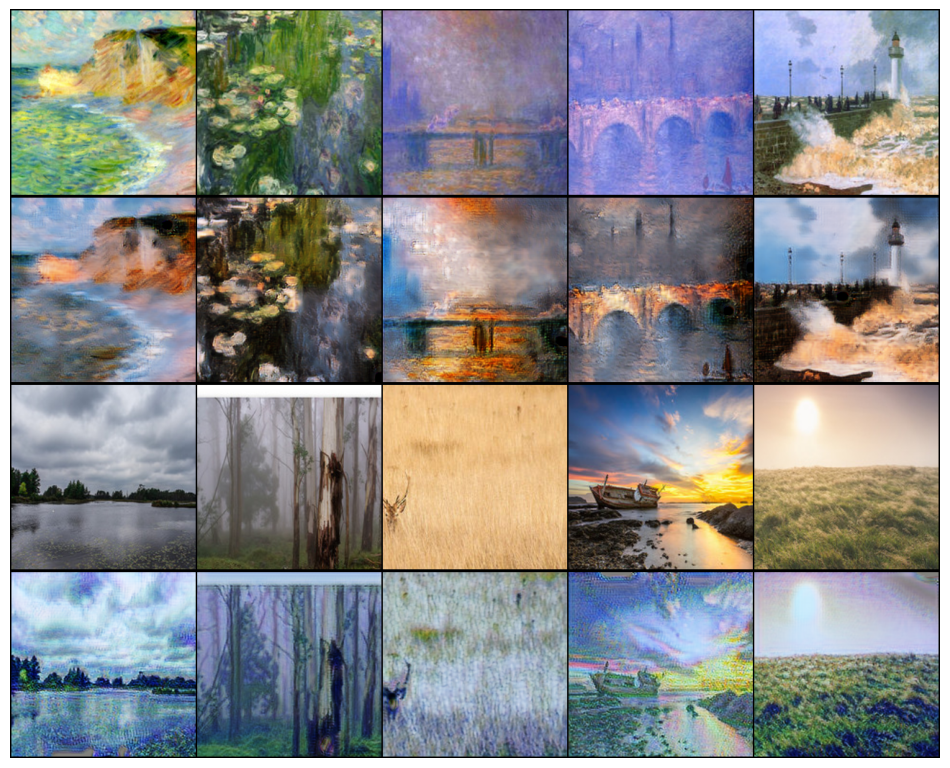

EPOCH: 5.000  loss_GAN: 0.588  loss_cycle: 0.176  loss_identity: 0.162  loss_G: 3.154  loss_D: 0.164  (10218.41s - 0.00s remaining)


In [15]:
import random #Showing a few converted images 
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        real_A, real_B = batch

        loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B = generator_train_step((G_AB,G_BA), optimizer_G, real_A, real_B)
        loss_D_A = discriminator_train_step(D_A, real_A, fake_A, optimizer_D_A)
        loss_D_B = discriminator_train_step(D_B, real_B, fake_B, optimizer_D_B)
        loss_D = (loss_D_A + loss_D_B) / 2

        log.record(epoch+(1+bx)/N, loss_D=loss_D.item(), loss_G=loss_G.item(),
                   loss_GAN=loss_GAN.item(), loss_cycle=loss_cycle.item(),
                   loss_identity=loss_identity.item(), end='\r')
    generate_sample()

    log.report_avgs(epoch+1)

100%|██████████| 106/106 [00:02<00:00, 40.55it/s]


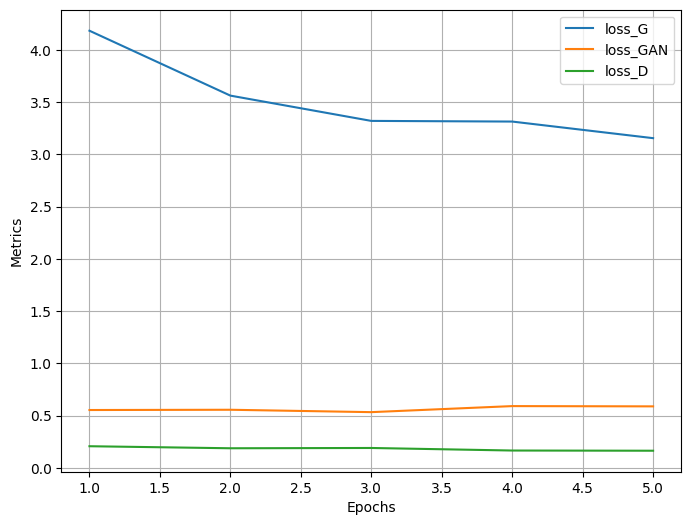

In [16]:
log.plot_epochs(['loss_G','loss_GAN', 'loss_D'])

In [17]:
from PIL import Image # Transforming an image of my choice 
import torchvision.transforms as transforms
import torch



# Define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resizing the image
    transforms.ToTensor(),         # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalization
])

# Load your favorite image or your picture
image_path = '/content/drive/MyDrive/Dataset/test.jpg'  
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  

# Move to the same device as your model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image = image.to(device)

transformed_image = G_BA(image)  

# Convert back to an image
transformed_image = transformed_image.squeeze(0) 
transformed_image = transforms.functional.to_pil_image((transformed_image + 1) / 2)  # Denormalize and convert to PIL image

# Save the transformed image
save_path = '/content/drive/MyDrive/Dataset/transformed_image.jpg'  # Replace with the path where you want to save the image
transformed_image.save(save_path)
